# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install -U sagemaker opencv-python
#!pip install -U torch
!pip install -U torchvision
!pip install -U smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.5/706.5 kB 43.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.6 MB/s eta 0:00:0000:0100:01
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Created wheel for sagemaker: filename=sagemaker-2.143.0-py2.py3-none-any.whl size=948773 sha256=f822abc8eb0bba4602326a526304dbf9c7ad4062023fa02f80f857c6902dd2a9
  Stored in directory: /home/ec2-user/.cache/pip/wheels/32/f6/5d/e03b11d085866d773eb374773e61fa06b6dee10254b7be2639
Successfully built sagemaker
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.68
    Uninstalling opencv-python-4.7.0.68:


In [3]:
!sudo python3 -m pip install smdebug

In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os, shutil
from pathlib import Path
import pandas as pd
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter,HyperparameterTuner
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig, TensorBoardOutputConfig
import smdebug
import numpy as np
import torch
from sagemaker import get_execution_role
import smdebug

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import torchvision.models as models

Initialize some parameters that will be found usefull later 

In [5]:
bucket = "project-3-data"
client = boto3.client('s3')
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

if os.path.exists('dogImages'):
    os.remove('dogImages)## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3
 
# Command to download and unzip data

datadir = Path('dogImages')
datafile = 'dogImages.zip'

# check if we already downloaded the dataset
if os.path.exists('dogImages.zip'):
    print('file already downloaded')
else:          
    if os.path.exists(datadir) and datadir.is_dir():
        shutil.rmtree(datadir)
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip > /dev/null

--2023-03-28 16:49:29--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.136
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

100%[====================================>] 1,132,023,110 46.7MB/s   in 24s    

2023-03-28 16:49:53 (45.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



Upload dataset to S3

In [5]:
modes = ['train', 'test', 'valid']
for mode in modes:
    filendir = './dogImages/' + mode
    for root,dirs,files in os.walk(filendir):
        for file in files:
            parent_folder = root.split('/')[-1]
            if parent_folder[0]=='.':
                continue #skip hidden folders
            #print(parent_folder)
            local_path = os.path.join(root, file)
            s3_path = os.path.join('dataset', mode, parent_folder, file)
            #print(local_path)
            #print(s3_path)
            try:
                client.head_object(Bucket=bucket, Key=s3_path)
                print("Path found on S3! Skipping {}...".format(s3_path))
            except:
                client.upload_file(local_path, bucket, s3_path)

As we can see if we observe the files that we extracted, each set [train, test, valid] contains a series of folders containng images of each dataset. The naming consist of the following patter
-number
-breed
-the word 'dog' , optional
In order to have an idea about the dataset, we will have to explore each part of the dataset

In [6]:
tbreed = set()

modes = ['train', 'test', 'valid']
split_breeds = [dict(), dict(), dict()]
for i in range(len(modes)):
    mode = modes[i]
    filendir = './dogImages/' + mode
    for root,dirs,files in os.walk(filendir):
        if dirs and dirs[0][0]!='.': #for all non epty directories, that are not hidden
            breeds = [dir.split('.')[1] for dir in dirs]
            tbreed.update(breeds)
            breed_dict = {}
            for breed in breeds:
                split_breeds[i][breed]=0 #initialiaze each dictionary with the key being the dog breed, and value 0

        for file in files:
            if file.endswith('.jpg'):
                dog_breed = file[:-4].split('_')[:-1]
                split_breeds[i]["_".join(dog_breed)]+=1 #update each record in the dictionary to containg the number of images containing in the folder [breed]

In [7]:
print('There is a total of {} different dog breeds in the dataset'.format(len(tbreed)))
print('In the training dataset there are a total of {} different dog breeds'.format(len(split_breeds[0])))
print('In the test dataset there are a total of {} different dog breeds'.format(len(split_breeds[1])))
print('In the validation dataset there are a total of {} different dog breeds'.format(len(split_breeds[2])))

There is a total of 133 different dog breeds in the dataset
In the training dataset there are a total of 133 different dog breeds
In the test dataset there are a total of 133 different dog breeds
In the validation dataset there are a total of 133 different dog breeds


We can see that no dog breeds are missing in each part of the dataset
In order to get more specific details, we could contract a dataframe to describe each portion of the dataset

In [8]:
train_df = pd.DataFrame.from_dict(split_breeds[0], orient='index', columns=['train_dataset_size'])
test_df = pd.DataFrame.from_dict(split_breeds[1], orient='index', columns=['test_dataset_size'])
val_df = pd.DataFrame.from_dict(split_breeds[2], orient='index', columns=['validation_dataset_size'])
total_df = pd.concat([train_df, test_df, val_df], axis=1)
total_df.head()

,train_dataset_size,test_dataset_size,validation_dataset_size
Neapolitan_mastiff,31,4,4
Airedale_terrier,52,6,7
Beagle,59,8,7
Basset_hound,73,10,9
German_pinscher,47,6,6


And eet some statistics about each dataset

In [9]:
total_df.describe()

,train_dataset_size,test_dataset_size,validation_dataset_size
count,133.000000,133.000000,133.000000
mean,50.225564,6.285714,6.278195
std,11.863885,1.712571,1.350384
min,26.000000,3.000000,4.000000
25%,42.000000,5.000000,6.000000
50%,50.000000,6.000000,6.000000
75%,61.000000,8.000000,7.000000
max,77.000000,10.000000,9.000000


It would be helpful to know the total number of photos that each part of the dateset contains

In [10]:
total_df.sum()

train_dataset_size         6680
test_dataset_size           836
validation_dataset_size     835
dtype: int64

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.005, 0.01),
    "batch_size": CategoricalParameter([16, 32, 64, 128]),
    "epochs": IntegerParameter(2, 5)
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definition = [{"Name": "Test Loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definition,
    max_jobs=4,
    max_parallel_jobs=2
)# TODO: Your HP tuner here

In [8]:
##### TODO: Fit your HP Tuner

tuner.fit({
        "train" : "s3://{}/{}/{}/".format(bucket, 'dataset', 'train') , 
        "test" : "s3://{}/{}/{}".format(bucket, 'dataset', 'test') ,
        "validation" : "s3://{}/{}/{}".format(bucket, 'dataset', 'valid')
}, wait=True) 
 # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [9]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-30 08:28:03 Starting - Preparing the instances for training
2023-03-30 08:28:03 Downloading - Downloading input data
2023-03-30 08:28:03 Training - Training image download completed. Training in progress.
2023-03-30 08:28:03 Uploading - Uploading generated training model
2023-03-30 08:28:03 Completed - Resource reused by training job: pytorch-training-230330-0752-003-7e0c988b


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"128"',
 'epochs': '3',
 'lr': '0.008517109452948923',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-30-07-52-44-878"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-07-52-44-878/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
#have hard coded them because hp tuning took some time and the server shutdown
hyperparameters = {"epochs": 3, "batch_size": 128, "lr": 0.008517109452948923}

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
                "include_regex": "CrossEntropyLoss_output_0", 
                "train.save_interval": "100","eval.save_interval": "10"})
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debug_config = DebuggerHookConfig(collection_configs=collection_configs)

In [ ]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large", 
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    rules=rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config
)# TODO: Your estimator here

estimator.fit({
        "train" : "s3://{}/{}/{}/".format(bucket, 'dataset', 'train') , 
        "test" : "s3://{}/{}/{}".format(bucket, 'dataset', 'test') ,
        "validation" : "s3://{}/{}/{}".format(bucket, 'dataset', 'valid')
}, wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-30-09-13-46-387


2023-03-30 09:13:48 Starting - Starting the training job...
2023-03-30 09:14:14 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2023-03-30 09:14:54 Downloading - Downloading input data............
2023-03-30 09:16:55 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-30 09:17:01,206 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-30 09:17:01,210 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-30 09:17:01,218 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-30 09:17:01,222 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-30 09:17:01,432 sagemaker-training-toolkit INFO     No GPUs detected (norma

In [12]:
# TODO: Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print("Training jobname: {}".format(training_job_name))

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2023-03-30-09-13-46-387
[2023-03-30 10:47:35.929 ip-172-16-115-17.ec2.internal:8121 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-30 10:47:35.955 ip-172-16-115-17.ec2.internal:8121 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/debug-output
[2023-03-30 10:47:36.494 ip-172-16-115-17.ec2.internal:8121 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-30 10:47:37.514 ip-172-16-115-17.ec2.internal:8121 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight']
2
3


In [13]:
from smdebug import modes
trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN)
tensor_name = "CrossEntropyLoss_output_0"

In [14]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


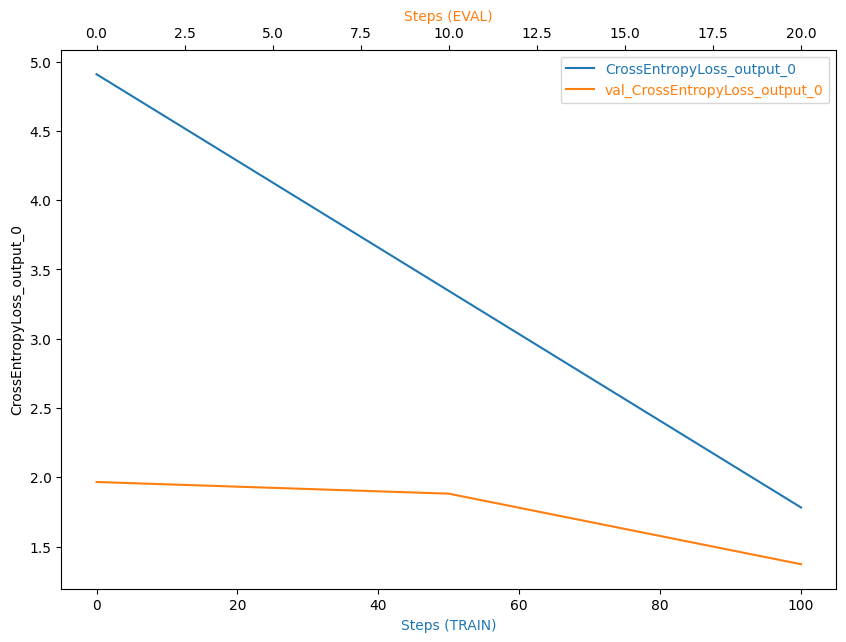

In [16]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?    
From the graph there in not a sign of any anomalies.  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?  
Anomalies would be shown as the crossEntropyLoss have an increasing tedency. In order to cure such cases, we could revisit our training dataset to add more or different transformers, change the model parameteres and the part of the model that we actually train [since we used a pretrained model as a base]

In [17]:
# TODO: Display the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-570128152225/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/profiler-output


Profiler data from system is available


In [18]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-30 10:48:07.970 ip-172-16-115-17.ec2.internal:8121 INFO metrics_reader_base.py:134] Getting 92 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [19]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/rule-output


In [20]:
! aws s3 ls {rule_output_path} --recursive

2023-03-30 10:45:52     374839 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-30 10:45:51     222755 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-30 10:45:47        193 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-30 10:45:47        201 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-30 10:45:47       1983 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-30 10:45:47        127 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-30 10:45:47        200 pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-03-30-09-13-46-387/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-570128152225/pytorch-tr

In [22]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [23]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

My initial thought was to use the 'train_model.py' file for the inference. But it was causing me the following error   

`2023-03-21 18:36:13,809 [INFO ] W-9000-model_1-stdout MODEL_LOG -     import smdebug.pytorch as smd  `

`2023-03-21 18:36:13,809 [INFO ] W-9000-model_1-stdout MODEL_LOG - ModuleNotFoundError: No module named 'smdebug'`  

The instructor's suggestion was to use a try/catch block in the smdebug import, but it may caused issues to the working file. So I made a copy of the 'train_model.py' file, named in 'train_model_no_smdebug.py' and removed everything regarding smdebug and hooks. Then, retrained the model and will use that one for the inference.
Also, it turned out that [after many attempts] there was something wrong in the model. So I changes the trainable portion of the model to something more straight forward.

In [13]:
hyperparameters = {"epochs": 3, "batch_size": 128, "lr": 0.008517109452948923} #same as before

#rules = [
#    Rule.sagemaker(rule_configs.vanishing_gradient()),
#    Rule.sagemaker(rule_configs.overfit()),
#    Rule.sagemaker(rule_configs.loss_not_decreasing()),
#    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
#]

estimator2 = PyTorch(
    entry_point="train_model_no_smdebug.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge", 
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
#    rules=rules
)# TODO: Your estimator here

estimator2.fit({
        "train" : "s3://{}/{}/{}/".format(bucket, 'dataset', 'train') , 
        "test" : "s3://{}/{}/{}".format(bucket, 'dataset', 'test') ,
        "validation" : "s3://{}/{}/{}".format(bucket, 'dataset', 'valid')
}, wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-01-16-58-16-806


2023-04-01 16:58:17 Starting - Starting the training job...
2023-04-01 16:58:33 Starting - Preparing the instances for training...
2023-04-01 16:59:20 Downloading - Downloading input data......
2023-04-01 17:00:25 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-01 17:00:39,661 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-01 17:00:39,663 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-01 17:00:39,672 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-01 17:00:39,674 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-01 17:00:39,989 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-01 17:00:40,002 sagemaker-training-toolkit INFO     No GPUs detected (normal if 

It seems that the simpler model can perform better than the more complicated.

In [14]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In case something goes wrong, we won't have to re train the model. So we can save a few money and time.

In [49]:
#from sagemaker.pytorch import PyTorch
#estimator2 = PyTorch.attach("pytorch-training-2023-04-01-16-58-16-806")

Let's take a look where the data are located

In [50]:
model_data_loc = estimator2.model_data
print(model_data_loc)

s3://sagemaker-us-east-1-570128152225/pytorch-training-2023-04-01-16-58-16-806/output/model.tar.gz


Now it is time to train our model. We will use the `inference.py` file that we created

In [26]:
pytorch_model2 = PyTorchModel(
    model_data=model_data_loc,
    role=role, 
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.8',
    predictor_cls=ImagePredictor) 

In [27]:
predictor2 = pytorch_model2.deploy(initial_instance_count=1, instance_type="ml.m5.large")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-01-18-11-43-663
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-01-18-11-44-306
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-01-18-11-44-306


-----!

And now it is time to make some predictions. First, let's pick a photo

In [60]:
img_loc = "dogImages/valid/082.Havanese/Havanese_05637.jpg"

with open (img_loc, 'rb') as f :
    bimage = f.read()
    #image = bytearray(image)

In [61]:
from PIL import Image
import io
image = Image.open(io.BytesIO(bimage))

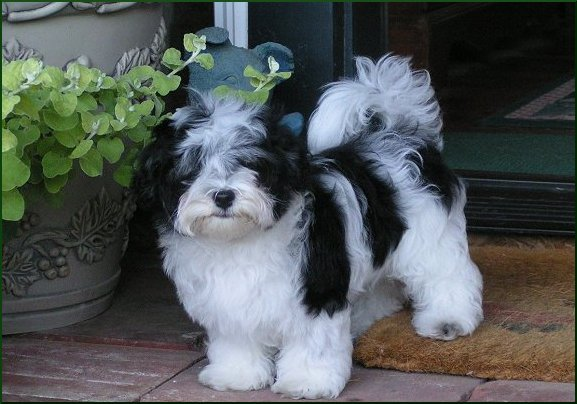

In [62]:
display(image)

And now, using the predictor we deployed let's make a prediction

In [63]:
response2=predictor2.predict(bimage, initial_args={"ContentType": "image/jpeg"})

In [64]:
print('The prediction label: {}'.format(np.argmax(response2[0])+1))

The prediction label: 82


In [65]:
print(len(response2[0]))

133


Time for a cleanup

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor2.delete_endpoint()